# Retrieving Data

In [150]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
webs = ['https://inshorts.com/en/read/business',
        'https://inshorts.com/en/read/technology']

def dataset_builder(webs):
    news_data = []
    for url in webs:
        news_cat = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
#         headline = soup.find_all('div', class_=["news-card-title news-right-box"])
#         body = soup.find_all('div', class_=["news-card-content news-right-box"])
        
        news_articles = [{'headline': headline.find('span', attrs={'itemprop': 'headline'}).string,
                         'article_body': body.find('div', attrs={'itemprop': 'articleBody'}).string,
                         'category': news_cat}
                        
                         for headline, body in
                         zip (soup.find_all('div', class_=['news-card-title news-right-box']),
                              soup.find_all('div', class_=['news-card-content news-right-box'])
                             )
                        ] 
        
        news_data.extend(news_articles)
    
    df = pd.DataFrame(news_data)
    df = df[['headline', 'article_body', 'category']]
    
    return df
    
    

In [6]:
news_df = dataset_builder(webs)
news_df.head(10)

headline  \
0  Unaware if staff worked on China military proj...   
1  Interest rate on Small Savings Schemes reduced...   
2  India wins trade dispute with US over solar pa...   
3  Travel planner Cox & Kings defaults, shares fa...   
4  Tata Chemicals to build UK's biggest carbon ca...   
5  UK's AdiGroup joins Jet Airways employees to b...   
6  Poultry farmers seek 'Agriculture' status unde...   
7  Godrej family seeks external advice in dispute...   
8  ONGC invites partners to raise output from 64 ...   
9  India's forex reserves hit record high of $426...   

                                        article_body  category  
0  Responding to a Bloomberg report that Huawei's...  business  
1  The government has reduced interest rate on Sm...  business  
2  The World Trade Organisation (WTO) ruled that ...  business  
3  Shares of Mumbai-based Cox & Kings fell 10% to...  business  
4  Tata Chemicals Europe is planning to build the...  business  
5  London-based AdiGroup and a consortium of Jet ...  business  
6  The Karnataka Poultry Farmers and Breeders Ass...  business  
7  The Godrej family has sought advice from exter...  business  
8  State-run ONGC said it has issued a tender see...  business  
9  India's foreign exchange reserves touched a li...  business

In [7]:
news_df.category.value_counts()

business      25
technology    24
Name: category, dtype: int64

# Text wrangling and Data Pre-processing

In [14]:
# pip install -U spacy

In [ ]:
# you will need:
# spacy engish models & language (python -m spacy download en)
# contractions.py from https://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/bonus%20content/nlp%20proven%20approach

In [31]:
import spacy
import nltk
# nltk.download("stopwords")
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

nlp = spacy.load('en', parse = True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

## Removing HTML tags

In [28]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>This sentences will be returned</h2></html>')

'This sentences will be returned'

## Removing accented characters

In [29]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

## Expand contractions

In [50]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("don't worry if you've a lot of contractions in your sentences, you'll be able to expand it using this function.")

'do not worry if you have a lot of contractions in your sentences, you will be able to expand it using this function.'

## Removing special characters


In [48]:
def remove_special_chars(text, remove_digits=False):
    
    pattern = r'[^a-zA-Z0-9\s]+' if not remove_digits else r'[^a-zA-Z\s]+'
    text = re.sub(pattern, '', text)
    return text

remove_special_chars("3;2;1!Hey, the punctuations are gone.", 
                     remove_digits=True)

'Hey the punctuations are gone'

## Text Stemming


In [53]:
def stem_text(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

stem_text("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

Word stems are also known as the base form of a word, and we can create new words by attaching affixes to them in a process known as inflection. Consider the word JUMP. You can add affixes to it and form new words like JUMPS, JUMPED, and JUMPING. In this case, the base word JUMP is the word stem.

Stemming helps us in standardizing words to their base or root stem, irrespective of their inflections, which helps many applications like classifying or clustering text, and even in information retrieval.

Do note that usually stemming has a fixed set of rules, hence, the root stems may not be lexicographically correct. Which means, the stemmed words may not be semantically correct, and might have a chance of not being present in the dictionary

## Text lemmatization

In [51]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crashed yesterday , ours crash daily'

Lemmatization is very similar to stemming, where we remove word affixes to get to the base form of a word. However, the base form in this case is known as the root word, but not the root stem. The difference being that the root word is always a lexicographically correct word (present in the dictionary), but the root stem may not be so. Thus, root word, also known as the lemma, will always be present in the dictionary.

Do note that the lemmatization process is considerably slower than stemming, because an additional step is involved where the root form or lemma is formed by removing the affix from the word if and only if the lemma is present in the dictionary.

## Removing Stopwords

In [54]:
def remove_stopwords(text, is_lower_case= False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

remove_stopwords("The, and, if are few examples of stopwords, while computer is not.")

', , examples stopwords , computer not .'

## Building a Text Normalizer

In [65]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                   accented_char_removal=True, text_lower_case=True, 
                   text_lemmatization=True, special_char_removal=True, 
                   stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    
    for doc in corpus:
        #strip html tags
        if html_stripping:
            doc = strip_html_tags(doc)
            
        #expand contractions
        if contraction_expansion:
            doc = expand_contractions(doc)
            
        #remove accented characters    
        if accented_char_removal:
            doc = remove_accented_chars(doc)
            
        #lower case the words
        if text_lower_case:
            doc = doc.lower()
        
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        
        #lemmatize the text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        
        #remove special characters
        if special_char_removal:
            doc = remove_special_chars(doc, remove_digits=remove_digits)
        
        #remove the stopwords
        if stopword_removal:
            doc = remove_stopwords(doc)
    
        normalized_corpus.append(doc)
    
    return normalized_corpus

In [66]:
news_df['full_text'] = news_df["headline"].map(str)+ '. ' + news_df["article_body"]

In [67]:
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_text = list(news_df['clean_text'])
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'clean_text': 'interest rate small saving scheme reduce ppf fetch government reduce interest rate small saving scheme include public provident fund ppf fetch interest rate july september quarter exist year senior citizen saving scheme fetch sukanya samriddhi account scheme interest rate small saving scheme last revise october december quarter',
 'full_text': 'Interest rate on Small Savings Schemes reduced, PPF to fetch 7.9%. The government has reduced interest rate on Small Savings Schemes, including Public Provident Fund (PPF), which will now fetch 7.9% interest rate for the July-September quarter, down from existing 8%. The 5-year Senior Citizen Savings Scheme will fetch 8.6%, while Sukanya Samriddhi Account Scheme 8.4%. The interest rate on small savings schemes was last revised for the October-December quarter.'}

In [75]:
# save the dataset into csv files
news_df.to_csv('news.csv', index=False, encoding='utf-8')

In [81]:
news_df.head()

headline  \
0  Unaware if staff worked on China military proj...   
1  Interest rate on Small Savings Schemes reduced...   
2  India wins trade dispute with US over solar pa...   
3  Travel planner Cox & Kings defaults, shares fa...   
4  Tata Chemicals to build UK's biggest carbon ca...   

                                        article_body  category  \
0  Responding to a Bloomberg report that Huawei's...  business   
1  The government has reduced interest rate on Sm...  business   
2  The World Trade Organisation (WTO) ruled that ...  business   
3  Shares of Mumbai-based Cox & Kings fell 10% to...  business   
4  Tata Chemicals Europe is planning to build the...  business   

                                           full_text  \
0  Unaware if staff worked on China military proj...   
1  Interest rate on Small Savings Schemes reduced...   
2  India wins trade dispute with US over solar pa...   
3  Travel planner Cox & Kings defaults, shares fa...   
4  Tata Chemicals to build UK's biggest carbon ca...   

                                          clean_text  
0  unaware staff work china military project say ...  
1  interest rate small saving scheme reduce ppf f...  
2  india win trade dispute us solar panel incenti...  
3  travel planner cox king default share fall rec...  
4  tata chemical build uks big carbon capture pla...

# Sentiment Analysis

In [82]:
from textblob import TextBlob
sentiment_scores = [round(TextBlob(article).sentiment.polarity, 2) for article in news_df['clean_text']]
sentiment_category = ['positive' if score > 0
                     else 'negative' if score < 0
                     else 'neutral'
                     for score in sentiment_scores]

In [92]:
df = pd.DataFrame([list(news_df['category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                                  \
                        count      mean       std   min    25%    50%     75%   
news_category                                                                   
business                 25.0  0.012400  0.122756 -0.40 -0.010  0.020  0.0900   
technology               24.0  0.051667  0.176898 -0.26 -0.035  0.085  0.1575   

                     
                max  
news_category        
business       0.23  
technology     0.50

In [93]:
df.head()

news_category  sentiment_score sentiment_category
0      business            -0.01           negative
1      business            -0.15           negative
2      business             0.02           positive
3      business            -0.15           negative
4      business             0.13           positive

In [107]:
df['sentiment_score'].sort_values(ascending=False).head()

32    0.50
24    0.23
31    0.22
47    0.21
33    0.20
Name: sentiment_score, dtype: float64

In [108]:
df['sentiment_score'].sort_values(ascending=False).tail()

28   -0.17
35   -0.22
42   -0.25
41   -0.26
5    -0.40
Name: sentiment_score, dtype: float64

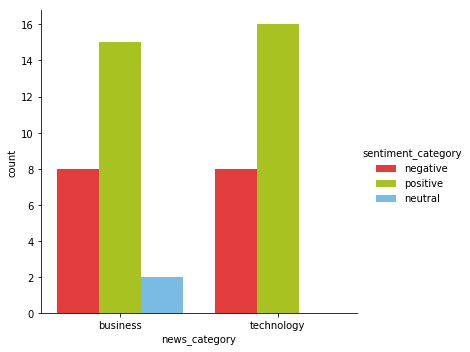

In [97]:
factor_plot = sns.catplot(x="news_category", hue="sentiment_category", 
                             data=df, kind="count", 
                             palette={"negative": "#FE2020", "positive": "#BADD07", "neutral": "#68BFF5"})

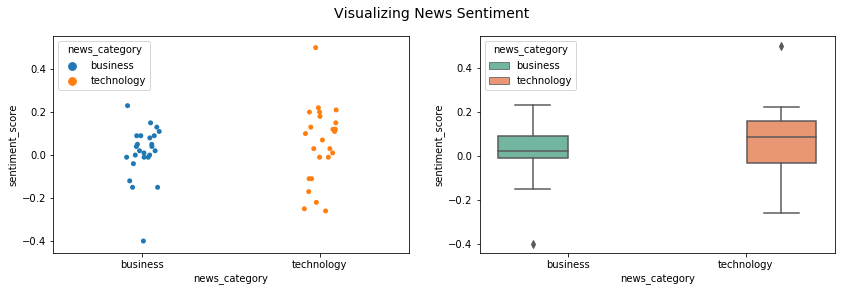

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
strip_plot = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
box_plot = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
title = fig.suptitle('Visualizing News Sentiment', fontsize=14)

In [140]:
df[df['news_category'] == 'technology'].sort_values(by = 'sentiment_score', ascending = False)

news_category  sentiment_score sentiment_category
32    technology             0.50           positive
31    technology             0.22           positive
47    technology             0.21           positive
26    technology             0.20           positive
33    technology             0.20           positive
25    technology             0.18           positive
48    technology             0.15           positive
39    technology             0.13           positive
34    technology             0.12           positive
36    technology             0.12           positive
43    technology             0.11           positive
40    technology             0.10           positive
29    technology             0.07           positive
46    technology             0.03           positive
37    technology             0.03           positive
45    technology             0.01           positive
44    technology            -0.01           negative
30    technology            -0.01           negative
38    technology            -0.11           negative
27    technology            -0.11           negative
28    technology            -0.17           negative
35    technology            -0.22           negative
42    technology            -0.25           negative
41    technology            -0.26           negative

In [141]:
df[df['news_category'] == 'business'].sort_values(by = 'sentiment_score', ascending = False)

news_category  sentiment_score sentiment_category
24      business             0.23           positive
16      business             0.15           positive
4       business             0.13           positive
10      business             0.11           positive
21      business             0.09           positive
19      business             0.09           positive
12      business             0.09           positive
8       business             0.08           positive
23      business             0.05           positive
20      business             0.05           positive
22      business             0.04           positive
14      business             0.04           positive
9       business             0.02           positive
2       business             0.02           positive
17      business             0.01           positive
7       business             0.00            neutral
11      business             0.00            neutral
18      business            -0.01           negative
0       business            -0.01           negative
15      business            -0.01           negative
6       business            -0.04           negative
13      business            -0.12           negative
3       business            -0.15           negative
1       business            -0.15           negative
5       business            -0.40           negative

In [142]:
pos_tech_id = df[df['news_category'] == 'technology'].sort_values(by = 'sentiment_score', ascending = False).index[0]
neg_tech_id = df[df['news_category'] == 'technology'].sort_values(by = 'sentiment_score', ascending = False).index[-1]

In [143]:
print('Most Negative Technology Article:', news_df.iloc[neg_tech_id][['article_body']][0])
print()
print('Most Positive Technology Article:', news_df.iloc[pos_tech_id][['article_body']][0])

Most Negative Technology Article: Over 120 Google employees have signed a petition to exclude Google from representation in the San Francisco Pride Parade on June 30. They stated, whenever they press for change, Google says it'll "take a hard look at [LGBTQ+-related] policies" but doesn't give a commitment to improve. However, San Francisco Pride has confirmed Google as a continued participant in the parade.

Most Positive Technology Article: Google researchers revealed they used around 2,000 YouTube videos of the viral 2016 Mannequin Challenge to help its AI model better predict depth in videos shot with a moving camera. Researchers turned the clips into 2D images, estimated the camera pose and then created depth maps. This could help self-driving cars and robots better navigate unfamiliar areas, researchers said.


In [147]:
pos_bus_id = df[df['news_category'] == 'business'].sort_values(by = 'sentiment_score', ascending = False).index[0]
neg_bus_id = df[df['news_category'] == 'business'].sort_values(by = 'sentiment_score', ascending = False).index[-1]

In [149]:
print('Most Negative Business Article:', news_df.iloc[neg_bus_id][['article_body']][0])
print()
print('Most Positive Business Article:', news_df.iloc[pos_bus_id][['article_body']][0])

Most Negative Business Article: London-based AdiGroup and a consortium of Jet Airways employees on Friday said they will bid for 75% of the airline, which is currently facing bankruptcy proceedings. AdiGroup Chairman Sanjay Viswanathan said he hoped to make a formal bid by end of this month. He said the partnership may invest up to ₹5,000 crore as part of the airline's restructuring plan.

Most Positive Business Article: Fugitive diamantaire Nirav Modi was on Thursday further remanded to judicial custody until July 25. The 48-year-old, wanted in the ₹14,000-crore PNB fraud case, appeared for the hearing via videolink from London's Wandsworth prison. Nirav's legal team requested the court to provide him with an internet-free laptop to review the Indian government's 5,000-page case against him in prison.
